# Imports

In [80]:
import os
import sys
import pickle
from typing import Tuple

import pandas as pd
from pandas import DataFrame

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import (
    load_model,
    Sequential
)
from keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten
)
from keras.optimizers import Adam

In [71]:
CROSS_COLUMN_QSRR_PATH: str = os.path.dirname(os.getcwd())

In [74]:
if CROSS_COLUMN_QSRR_PATH not in sys.path:
    sys.path.insert(0, CROSS_COLUMN_QSRR_PATH)

In [75]:
from qsrr.analysis import analyze_model

ImportError: cannot import name 'Exception' from 'qsrr.exceptions' (C:\Users\user4\PycharmProjects\cross_column_qsrr\qsrr\exceptions\__init__.py)

# Code

In [31]:
def get_model(
    input_shape: Tuple[int, ...]
):
    
    _model: Sequential = Sequential()
    
    _model.add(
        Conv2D(
            filters=64,
            kernel_size=(3, 3),
            input_shape=input_shape,
            activation='relu'
        )
    )
        
    _model.add(Flatten())

    _model.add(Dense(64, activation='relu'))
        
    _model.add(Dropout(0.1))
    
    _model.add(Dense(32, activation='relu'))
    _model.add(Dense(16, activation='relu'))
    
    _model.add(Dense(1, activation='linear'))

    _model.compile(
        loss='mean_squared_error',
        optimizer=Adam(0.001)
    )

    return _model

# Load Data

In [32]:
DATA_PATH: str = os.path.join(CROSS_COLUMN_QSRR_PATH, "data")
SMRT_DATASET: str = os.path.join(DATA_PATH, "2023-11-18-smrt_dataset.csv")
SMRT_DATASET_SMILES: str = os.path.join(DATA_PATH, "2023-11-18-smrt_dataset_smiles.csv")
SMRT_DATASET_ENCODED_SMILES: str = os.path.join(DATA_PATH, "2023-11-18-smrt_dataset_encoded_smiles.pkl")

In [33]:
_data_df = pd.read_csv(
    SMRT_DATASET_SMILES, 
    delimiter=','
)

In [34]:
display(_data_df)

,smiles,rt
0,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,687.8
1,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC,590.7
2,Oc1cccc2c(O)nccc12,583.6
3,OC1=NCC2(CCN(CCc3ccccc3)CC2)O1,579.0
4,CC(C)(C)NC[C@H](O)COc1cccc2nc(O)[nH]c12,603.1
...,...,...
77890,CCOc1ccc(OCC)c(NS(=O)(=O)c2ccc(/C=C/c3onc(C)c3...,946.4
77891,COCCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(F)c3)C...,653.1
77892,COCCN=C(O)N1C[C@@H]2CN(S(=O)(=O)c3cccc(C)c3)C[...,648.2
77893,Cc1ccc(S(=O)(=O)N2C[C@@H]3CN(C(O)=Nc4ccccc4C)C...,783.9


In [35]:
with open(SMRT_DATASET_ENCODED_SMILES, "rb") as f:
    _encoded_smiles_arr: ndarray = pickle.load(f)

In [36]:
_encoded_smiles_arr.shape

(77895, 90, 54)

# Train/Test Split

In [37]:
TEST_RATIO: float = 0.3
RANDOM_STATE: int = 12345

In [38]:
_y_train, _y_test, _x_train, _x_test = train_test_split(
    _data_df["rt"],
    _encoded_smiles_arr,
    test_size=TEST_RATIO,
    random_state=RANDOM_STATE
)

In [39]:
display(_x_train.shape)
display(_x_test.shape)

(54526, 90, 54)

(23369, 90, 54)

In [40]:
display(_y_train.shape)
display(_y_test.shape)

(54526,)

(23369,)

In [41]:
max_length, vocabulary_size = _x_train.shape[1:]

In [42]:
_x_train = _x_train.reshape(_x_train.shape[0], max_length, vocabulary_size, 1)
_x_test = _x_test.reshape(_x_test.shape[0], max_length, vocabulary_size, 1)
_input_shape = (max_length, vocabulary_size, 1)

In [43]:
display(_input_shape)

(90, 54, 1)

In [49]:
_scaler = StandardScaler()
_y_train_sc: ndarray = _scaler.fit_transform(_y_train.values.reshape(-1, 1))

# Get & Train Model

In [56]:
_model = get_model(input_shape=_input_shape)

In [57]:
_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 88, 52, 64)        640       
                                                                 
 flatten_2 (Flatten)         (None, 292864)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                18743360  
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                

In [58]:
# 100 + 100

In [59]:
_history = _model.fit(
    _x_train,
    _y_train_sc,
    epochs=100,
    batch_size=512
)

Epoch 1/100
107/107 [==============================] - 22s 203ms/step - loss: 0.6516
Epoch 2/100
107/107 [==============================] - 22s 203ms/step - loss: 0.4982
Epoch 3/100
107/107 [==============================] - 22s 204ms/step - loss: 0.4249
Epoch 4/100
107/107 [==============================] - 22s 204ms/step - loss: 0.3754
Epoch 5/100
107/107 [==============================] - 22s 204ms/step - loss: 0.3381
Epoch 6/100
107/107 [==============================] - 22s 204ms/step - loss: 0.3061
Epoch 7/100
107/107 [==============================] - 22s 204ms/step - loss: 0.2833
Epoch 8/100
107/107 [==============================] - 22s 203ms/step - loss: 0.2660
Epoch 9/100
107/107 [==============================] - 22s 203ms/step - loss: 0.2450
Epoch 10/100
107/107 [==============================] - 22s 204ms/step - loss: 0.2316
Epoch 11/100
107/107 [==============================] - 22s 203ms/step - loss: 0.2170
Epoch 12/100
107/107 [==============================] - 22s 203

In [60]:
_history_df = pd.DataFrame.from_dict(_history.history)

<Axes: >

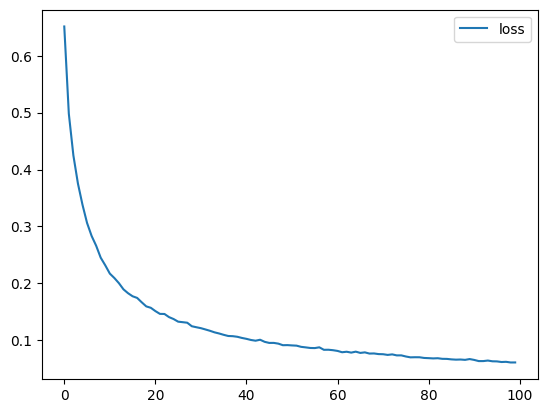

In [61]:
_history_df.plot()

In [62]:
_y_train_hat_sc = _model.predict(_x_train)
_y_test_hat_sc = _model.predict(_x_test)

731/731 [==============================] - 12s 16ms/step


In [63]:
_y_train_hat = _scaler.inverse_transform(_y_train_hat_sc)
_y_test_hat = _scaler.inverse_transform(_y_test_hat_sc)

In [83]:
analyze_model()

NameError: name 'analyze_model' is not defined

In [84]:
_model.save("C:\\Temp\\cnn_model.keras", save_format="keras")
_history_df.to_csv("C:\\Temp\\cnn_model_history.csv", index=False)

# Load trained model

In [86]:
_model = load_model("C:\\Temp\\cnn_model.keras")
_history_df = pd.read_csv("C:\\Temp\\cnn_model_history.csv")

# Evaluated trained model